# Physics-informed neural network (PINN) demo


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the boundary conditions of the system
- Outputs: estimate of the solution, $y(x)$

#### Differential Equation with B.C.

$$ -2y\frac{d^2y}{dx^2} + (\frac{dy}{dx})^2 -4= 0 $$

$$ y(0) = 1 $$

$$ y(1) = 0 $$

$$ y(3) = -8 $$





#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(x;\theta) \approx y(x)~,
$$


#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= \lambda_1(N\!N(0;\theta) - 0)^2 +  \frac{\lambda_2}{N} \sum^{N}_{i} \left( \frac{dN\!N(t_{i};\theta)}{dx} - x \right)^2
$$

#### Computing gradients

To compute gradients of the neural network with respect to its inputs, we will use `torch.autograd.grad`

## Initial setup

First, we define a few helper functions.

In [2]:
def exact_solution(x):
    u = 1-(x**2)
    return u

class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

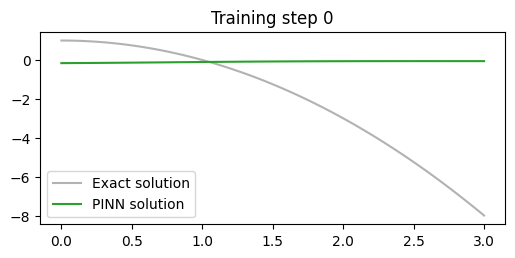

Epoch [1/6000], Loss: 69.4401
BC1 LOSS 1.3385509252548218
BC2 LOSS 0.008184387348592281
PDE LOSS 63.38020706176758


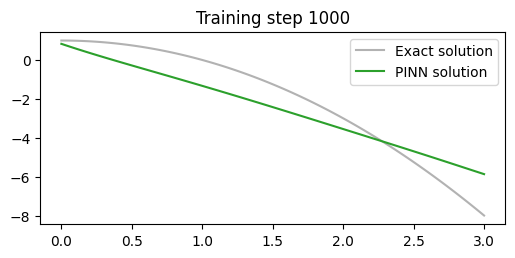

Epoch [1001/6000], Loss: 5.8084
BC1 LOSS 0.02946629747748375
BC2 LOSS 1.7758653163909912
PDE LOSS 4.549951076507568


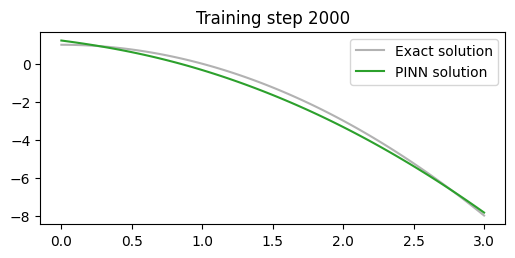

Epoch [2001/6000], Loss: 0.2069
BC1 LOSS 0.050093404948711395
BC2 LOSS 0.11194252222776413
PDE LOSS 0.024406015872955322


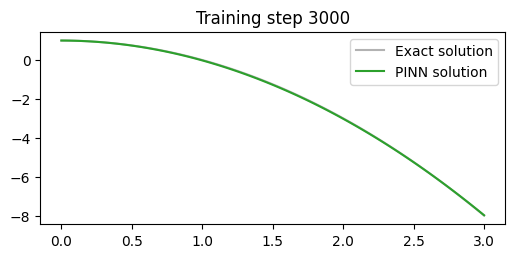

Epoch [3001/6000], Loss: 0.0028
BC1 LOSS 2.2589811123907566e-06
BC2 LOSS 0.0004543343384284526
PDE LOSS 0.00022710373741574585


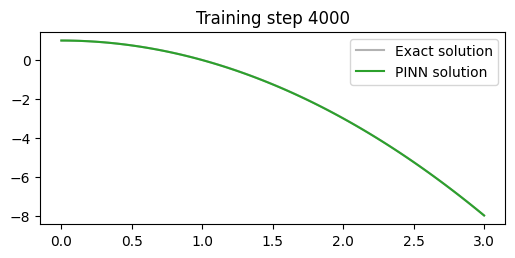

Epoch [4001/6000], Loss: 0.0012
BC1 LOSS 4.3252571231278125e-06
BC2 LOSS 1.444439658371266e-05
PDE LOSS 1.6934085579123348e-05


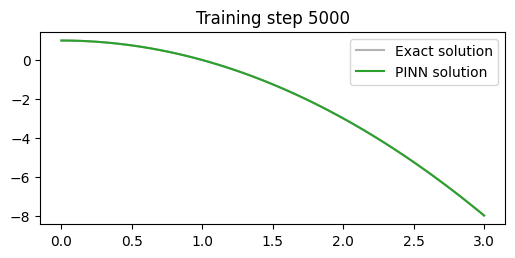

Epoch [5001/6000], Loss: 0.0007
BC1 LOSS 1.4959454119889415e-07
BC2 LOSS 1.3202153240854386e-05
PDE LOSS 1.5323203115258366e-06


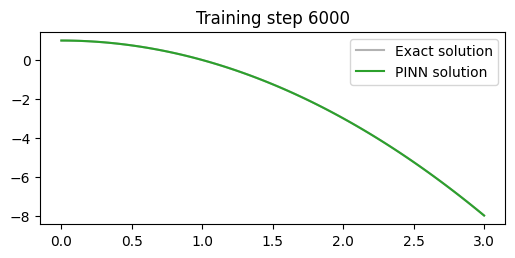

Epoch [6001/6000], Loss: 0.0003
BC1 LOSS 6.85037775838282e-07
BC2 LOSS 5.949481192146777e-07
PDE LOSS 6.30330987405614e-07


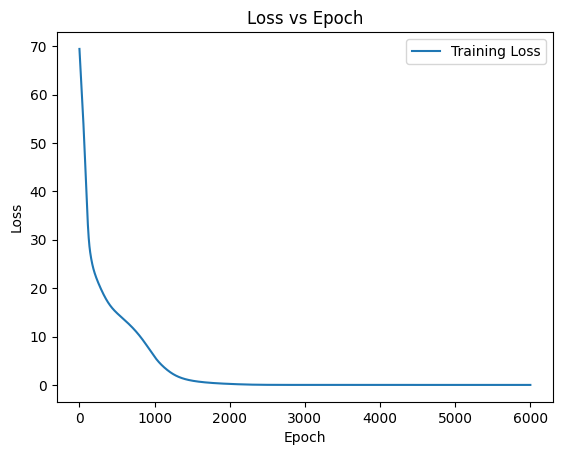

In [9]:
# define a neural network to train
pinn = FCN(1, 1, 64,3)

# define boundary points, for the boundary loss
x_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)# (1, 1)
x_boundary2 = torch.tensor(1.0).view(-1,1).requires_grad_(True)# (1, 1)
x_boundary3 = torch.tensor(3.0).view(-1,1).requires_grad_(True)# (1, 1)

# define training points over the entire domain, for the physics loss
x_physics = torch.linspace(0, 3,200).view(-1,1).requires_grad_(True)# (200, 1)

x_test = torch.linspace(0,3,100).view(-1,1) #(100, 1)

u_exact = exact_solution(x_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-4)
num_epochs = 6000
losses = []
for i in range(num_epochs+1):
    optimiser.zero_grad()

    # using the following hyperparameters
    lambda1, lambda2 = 0.9, 0.7

    # compute boundary loss
    u = pinn(x_boundary)# (1, 1)
    loss1 = (torch.squeeze(u)-1)**2

    u = pinn(x_boundary2)
    # dudx = torch.autograd.grad(u2, x_boundary2, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    # dudx2 = torch.autograd.grad(dudx, x_boundary2, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    loss2 = (torch.squeeze(u)-0)**2

    u = pinn(x_boundary3)
    loss3 = (torch.squeeze(u)+8)**2

    # compute physics loss
    u = pinn(x_physics)  # (20, 1)
    dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    dudx2 = torch.autograd.grad(dudx, x_physics, torch.ones_like(dudx), create_graph=True)[0]  # (20, 1)
    loss4 = torch.mean((-2*u*dudx2 + (dudx)**2-4)**2)

    # backpropagate joint loss, take optimiser step
    loss = lambda1* loss1 + lambda2* loss2 + lambda1*loss3 + lambda2*loss4
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

    # plot the result as training progresses
    if i % 1000 == 0:
        u = pinn(x_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(x_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
        print(f"Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}")
        print(f'BC1 LOSS {loss1}')
        print(f'BC2 LOSS {loss2}')
        print(f'PDE LOSS {loss3}')


plt.plot(range(1, num_epochs+2), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [5]:
print(u_exact)
print(u)

tensor([[ 1.0000],
        [ 0.9991],
        [ 0.9963],
        [ 0.9917],
        [ 0.9853],
        [ 0.9770],
        [ 0.9669],
        [ 0.9550],
        [ 0.9412],
        [ 0.9256],
        [ 0.9082],
        [ 0.8889],
        [ 0.8678],
        [ 0.8448],
        [ 0.8200],
        [ 0.7934],
        [ 0.7649],
        [ 0.7346],
        [ 0.7025],
        [ 0.6685],
        [ 0.6327],
        [ 0.5950],
        [ 0.5556],
        [ 0.5142],
        [ 0.4711],
        [ 0.4261],
        [ 0.3792],
        [ 0.3306],
        [ 0.2801],
        [ 0.2277],
        [ 0.1736],
        [ 0.1175],
        [ 0.0597],
        [ 0.0000],
        [-0.0615],
        [-0.1249],
        [-0.1901],
        [-0.2571],
        [-0.3260],
        [-0.3967],
        [-0.4692],
        [-0.5436],
        [-0.6198],
        [-0.6979],
        [-0.7778],
        [-0.8595],
        [-0.9431],
        [-1.0285],
        [-1.1157],
        [-1.2048],
        [-1.2957],
        [-1.3884],
        [-1.

Avg Percentage Error (excluding infinite values) is: 0.1306912007957998


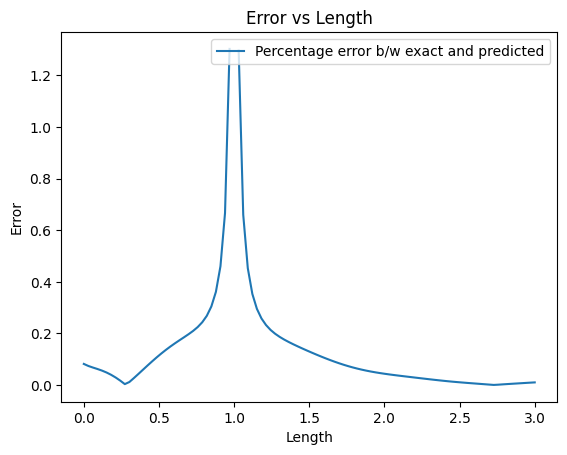

In [10]:
# Calculate error
diff = abs(u_exact - u) / abs(0.01 * u_exact)
# a1 = torch.mean(diff[0:33])
# a2 = torch.mean(diff[34:])
# print(a1)
# print(a2)


# Mask out infinite values
masked_diff = np.ma.masked_invalid(diff)

# Calculate mean excluding infinite values
mean_error = np.mean(masked_diff)

print(f'Avg Percentage Error (excluding infinite values) is: {mean_error}')

# Plot
plt.plot(x_test, diff, label='Percentage error b/w exact and predicted')
plt.xlabel('Length')
plt.ylabel('Error')
plt.title('Error vs Length')
plt.legend()
plt.show()


Overall RMSE is: 0.0010067281546071172


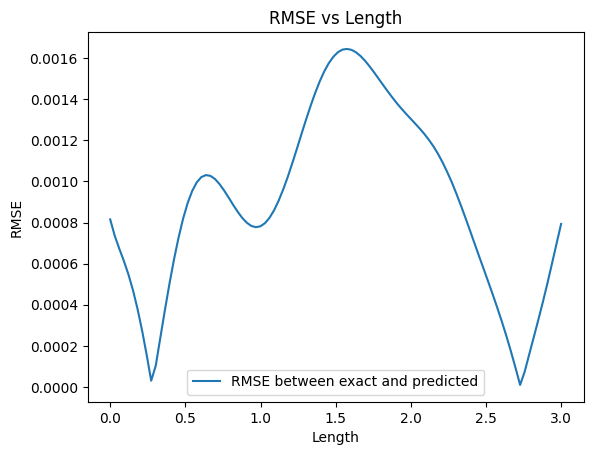

In [11]:
# Assuming u_exact and u are NumPy arrays
u_exact2 = u_exact.numpy()
u2 = u.numpy()

# Calculate RMSE at each point
rmse_per_point = np.sqrt(np.mean((u_exact2 - u2)**2, axis=1))
overall_rmse = np.sqrt(np.mean((u_exact2 - u2)**2))
print(f'Overall RMSE is: {overall_rmse}')

# Plot the RMSE at each point
plt.plot(x_test, rmse_per_point, label='RMSE between exact and predicted')
plt.xlabel('Length')
plt.ylabel('RMSE')
plt.title('RMSE vs Length')
plt.legend()
plt.show()
